In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm
import math

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

# Runs through all waveforms, tags kr83m S1, applies an S2 and drifttime cut and saves the area_per_channel (only events where all PMTs see something) of all runs in a dict

In [2]:
run_list = ['00186','00187','00188','00189','00190','00191']
PMTs_all_runs = {}
PMTs_fraction_all_runs = {}
for run in run_list:
    ctx = straxbra.XebraContext()
    peaks_data = ctx.get_array(run, 'peaks')
    waveform = peaks_data['data']
    integral = peaks_data['area']
    width = peaks_data['width'][:,5]
    timestamp = peaks_data['time']
    area_per_channel = peaks_data['area_per_channel']
    
    def CutCondition(waveform):  
        FirstPeak_area = sum(waveform[:15])
        SecondPeak_area = sum(waveform[15:])    
        if  FirstPeak_area > 100 and FirstPeak_area < 600 and SecondPeak_area > 40 and SecondPeak_area  < 200: 
            return(True)
        else:
            return(False)
    
    def S2_found(integral, width):
        if integral > 500 and width >200 and width < 2000:
            return True
        else:
            return False
        
    def Process(waveform,i):

        CutFlag = CutCondition(waveform[i])
        if CutFlag == True:

#         PrintWaveform(waveform)
            j = 1
            counter_timestamp = timestamp[i+j]
            threshold_timestamp = timestamp[i] + 55000
      
            while threshold_timestamp >= counter_timestamp and S2_found(integral = integral[i+j], width = width[i+j]) == False: 
                j += 1
                counter_timestamp = timestamp[i+j]           
            else:
                if S2_found(integral = integral[i+j], width = width[i+j]):
                    #PrintWaveform(waveform[i+j])
                    kr_s2_area.append(integral[i+j])
                    for k in range(len(PMT_area_list)):
                        if area_per_channel[i+j][1] > 0 and area_per_channel[i+j][2] > 0 \
                        and area_per_channel[i+j][3] > 0 and area_per_channel[i+j][4] > 0 \
                        and area_per_channel[i+j][5] > 0 and area_per_channel[i+j][6] > 0 \
                        and area_per_channel[i+j][7] > 0 \
                        :
                            PMT_area_list[k].append(area_per_channel[i+j][k+1])
                            sum_area = sum(area_per_channel[i+j][1:8])   
                            sample_list = []
                            for m in range(len(area_per_channel[i+j][1:8])):
                                sample_list.append(float(area_per_channel[i+j][1:8][m]))
                            sum_area = sum(sample_list)
                            
                            for n in range(len(PMT_area_list)):
                                if sum_area > area_per_channel[i+j][n+1]:
                                    PMT_area_fraction_list[n].append((area_per_channel[i+j][n+1])/sum_area)
                                       
                    return
                else:
                    return

    Area_s2_PMT1 = []
    Area_s2_PMT2 = []
    Area_s2_PMT3 = []
    Area_s2_PMT4 = []
    Area_s2_PMT5 = []
    Area_s2_PMT6 = []
    Area_s2_PMT7 = []
    
    Area_fraction_s2_PMT1 = []
    Area_fraction_s2_PMT2 = []
    Area_fraction_s2_PMT3 = []
    Area_fraction_s2_PMT4 = []
    Area_fraction_s2_PMT5 = []
    Area_fraction_s2_PMT6 = []
    Area_fraction_s2_PMT7 = []
    
    PMT_area_list = [Area_s2_PMT1, Area_s2_PMT2,Area_s2_PMT3,Area_s2_PMT4,Area_s2_PMT5,Area_s2_PMT6,Area_s2_PMT7]
    PMT_area_fraction_list = [Area_fraction_s2_PMT1, Area_fraction_s2_PMT2,Area_fraction_s2_PMT3,Area_fraction_s2_PMT4,Area_fraction_s2_PMT5,Area_fraction_s2_PMT6,Area_fraction_s2_PMT7]
    kr_s2_area = []



    for i in range(0,len(waveform)):
    
        Process(waveform,i)   
    

    PMTs_all_runs.update({run:PMT_area_list})
    PMTs_fraction_all_runs.update({run:PMT_area_fraction_list})


In [3]:
from scipy.stats import crystalball

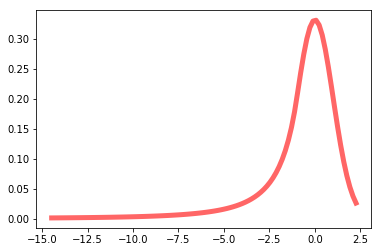

In [4]:
fig, ax = plt.subplots(1, 1)
beta, m = 1, 3
#mean, var, skew, kurt = crystalball.stats(beta, m, moments='mvsk')
x = np.linspace(crystalball.ppf(0.01, beta, m),crystalball.ppf(0.99, beta, m), 100)
ax.plot(x, crystalball.pdf(x, beta, m),'r-', lw=5, alpha=0.6, label='crystalball pdf')
plt.show()

In [11]:
# Function to define a Crystall Ball curve.
# See Stefan Bruenner's Thesis (p.30) for more details.
def crystal_ball_function(x, mu, sigma, alpha, n, N) -> float: # evtl. N als Parameter
    A = (n/abs(alpha))**n *np.exp(-((abs(alpha)**2)/(2)))
    B = (n/abs(alpha)) -abs(alpha)
    if sigma == 0:
        comp_val = 12
    else:
        comp_val = (float(x)-float(mu))/float(sigma)
#C = (n/abs(alpha)) *(1/(n-1)) *np.exp(-((abs(alpha)**2)/(2)))
#D = np.sqrt(math.pi/2) *(1 +erf(abs(alpha)/np.sqrt(2)))
#N = 1/(sigma*(C+D))
    if comp_val > (-1)*alpha:
        return N * np.exp(-(((x-mu)**2)/(2*sigma**2)))
    if comp_val <= (-1)*alpha:
        return N * A* (B - ((x-mu)/(sigma)))**(-n)

# curve_fit() has problems fitting piecewise defined functions, such as crystal_ball_function().
# Online I found, that one has to vectorize the function in order for curve_fit() to be able to fit it properly.
# Here's the corresponding link I found (accessed 12th March 2019): https://stackoverflow.com/questions/11129812/fitting-piecewise-function-in-python
# def crystal_ball_function_vec_self(x, mu, sigma, alpha, n, N):
# y = np.zeros(x.shape)
# for i in range(len(y)):
# y[i]=crystal_ball_function(x[i], mu, sigma, alpha, n, N)
# return y

# Plot area of PMTs in a histogram for multiple anode settings

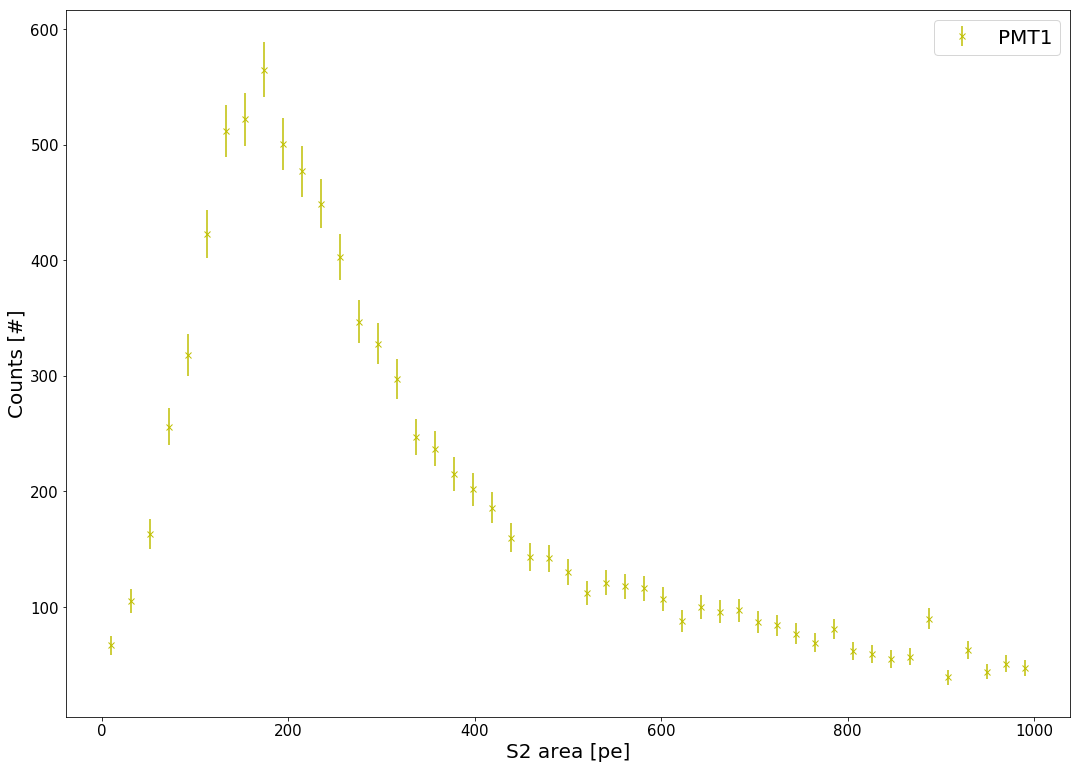

In [19]:
def log_gaus(x, h, mu, sigma):

    log_gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return log_gaus
def gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus




SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)



fig, ax = plt.subplots(figsize = (18,13))
p0_log = [10,10,10]
p0 = [300,150,30,10,10]
x_range = np.linspace(0,1000,100)
n_191_PMT1, binEdges = np.histogram(PMTs_all_runs['00191'][0], bins=np.linspace(0,1000,50)) 
n_191_PMT4, binEdges = np.histogram(PMTs_all_runs['00191'][3], bins=np.linspace(0,1000,50)) 
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])

#popt, pcov = curve_fit(crystal_ball_function, bincenters, n_191_PMT1, p0,  sigma=np.maximum(np.sqrt(n_191_PMT1)))
#popt_191_PMT1, pcov_PMT1 = curve_fit(gaus, bincenters, n_191_PMT1, p0,  sigma=np.maximum(np.sqrt(n_191_PMT1), np.ones_like(n_191_PMT1)))
#popt_191_PMT4, pcov_PMT4 = curve_fit(gaus, bincenters, n_191_PMT4, p0,  sigma=np.maximum(np.sqrt(n_191_PMT4), np.ones_like(n_191_PMT4)))

ax.errorbar(bincenters, n_191_PMT1, yerr=np.sqrt(n_191_PMT1),c = 'y', marker = 'x', fmt='.', label='PMT1')
#ax.errorbar(bincenters, n_191_PMT4, yerr=np.sqrt(n_191_PMT4),c = 'g', marker = 'x', fmt='.', label='PMT4')
#ax.plot(x_range,crystal_ball_function(x_range,*popt), color = 'y', label = 'xxx')
#ax.plot(x_range,gaus(x_range,*popt_191_PMT4), color = 'g', label = 'xxx')

ax.set_ylabel('Counts [#]')
ax.set_xlabel('S2 area [pe]')
plt.legend(loc =1,prop={'size': 20})
plt.show()

# Average S2 area for PMT 7 for multiple anode settings

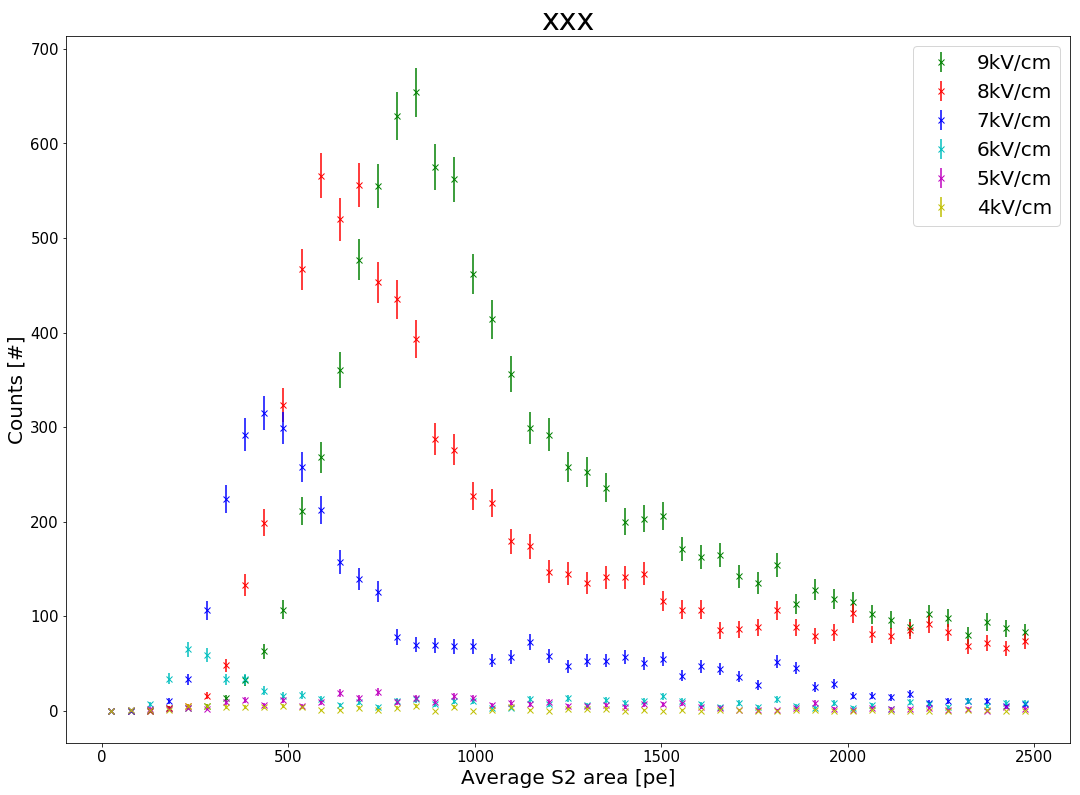

In [8]:
fig, ax = plt.subplots(figsize = (18,13))

n_186_PMT7, binEdges = np.histogram(PMTs_all_runs['00186'][6], bins=np.linspace(0,2500,50)) 
n_187_PMT7, binEdges = np.histogram(PMTs_all_runs['00187'][6], bins=np.linspace(0,2500,50)) 
n_188_PMT7, binEdges = np.histogram(PMTs_all_runs['00188'][6], bins=np.linspace(0,2500,50)) 
n_189_PMT7, binEdges = np.histogram(PMTs_all_runs['00189'][6], bins=np.linspace(0,2500,50)) 
n_190_PMT7, binEdges = np.histogram(PMTs_all_runs['00190'][6], bins=np.linspace(0,2500,50)) 
n_191_PMT7, binEdges = np.histogram(PMTs_all_runs['00191'][6], bins=np.linspace(0,2500,50)) 
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])

ax.errorbar(bincenters, n_191_PMT7, yerr=np.sqrt(n_191_PMT7),c = 'g', marker = 'x', fmt='.', label='9kV/cm')
ax.errorbar(bincenters, n_186_PMT7, yerr=np.sqrt(n_186_PMT7),c = 'r', marker = 'x', fmt='.', label='8kV/cm')
ax.errorbar(bincenters, n_187_PMT7, yerr=np.sqrt(n_187_PMT7),c = 'b', marker = 'x', fmt='.', label='7kV/cm')
ax.errorbar(bincenters, n_188_PMT7, yerr=np.sqrt(n_188_PMT7),c = 'c', marker = 'x', fmt='.', label='6kV/cm')
ax.errorbar(bincenters, n_189_PMT7, yerr=np.sqrt(n_189_PMT7),c = 'm', marker = 'x', fmt='.', label='5kV/cm')
ax.errorbar(bincenters, n_190_PMT7, yerr=np.sqrt(n_190_PMT7),c = 'y', marker = 'x', fmt='.', label='4kV/cm')


ax.set_title('xxx')
ax.set_ylabel('Counts [#]')
ax.set_xlabel('Average S2 area [pe]')
plt.legend()
plt.show()

# Area fraction of a krypton S2 seen by a selected PMT. S2s where a PMT sees nothing are excluded

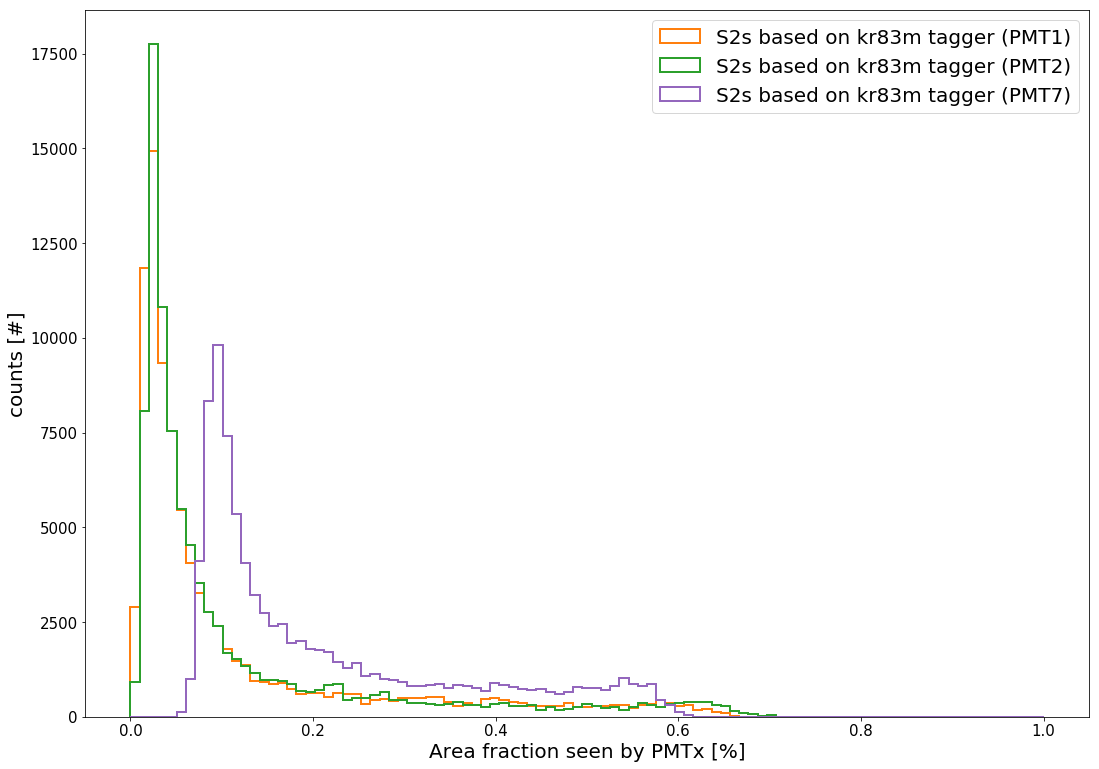

In [7]:
fig, ax = plt.subplots(figsize=(18,13))
bins_x = np.linspace(0,1,100)


plt.hist(PMTs_fraction_all_runs['00191'][0], bins=bins_x, histtype='step', color='C1', linewidth = 2, label = 'S2s based on kr83m tagger (PMT1)')
plt.hist(PMTs_fraction_all_runs['00191'][1], bins=bins_x, histtype='step', color='C2', linewidth = 2, label = 'S2s based on kr83m tagger (PMT2)')
plt.hist(PMTs_fraction_all_runs['00191'][6], bins=bins_x, histtype='step', color='C4', linewidth = 2, label = 'S2s based on kr83m tagger (PMT7)')
ax.set_xlabel('Area fraction seen by PMTx [%]', fontsize = 20)
ax.set_ylabel('counts [#]', fontsize = 20)
plt.legend()
plt.show()